In [ ]:
!pip install datasets

In [ ]:
import numpy as np
import math
from datasets import load_dataset
from nltk.tokenize import word_tokenize
import nltk
import re
from collections import Counter, defaultdict
from tqdm.auto import tqdm

def remove_symbols(tokenized_sentences):
    cleaned_sentences = [[token if re.search(r'\w', token) else '' for token in sentence] for sentence in tokenized_sentences]
    cleaned_sentences = [[token for token in sentence if token] for sentence in cleaned_sentences]
    return cleaned_sentences

def build_vocab(corpus, min_count=5):
    """
    Build vocabulary from corpus with minimum word frequency threshold
    """
    print("Building vocabulary...")
    word_freq = Counter([word for sentence in corpus for word in sentence])
    vocab = {'<PAD>': 0, '<UNK>': 1}
    idx = 2

    for word, freq in word_freq.items():
        if freq >= min_count:
            vocab[word] = idx
            idx += 1

    reverse_vocab = {idx: word for word, idx in vocab.items()}
    vocab_size = len(vocab)
    print(f"Vocabulary size: {vocab_size} words")
    return vocab, reverse_vocab, vocab_size

def generate_training_data(corpus, vocab, window_size=2):
    """
    Generate training data pairs for CBOW model with fixed context window size.
    """
    print("Generating training pairs...")
    X = []
    y = []
    context_size = window_size * 2

    for sentence in tqdm(corpus, desc="Processing sentences"):
        word_indices = [vocab.get(word, 1) for word in sentence]

        if len(word_indices) < context_size + 1:
            continue

        padded_sentence = [0] * window_size + word_indices + [0] * window_size

        for i in range(window_size, len(padded_sentence) - window_size):
            context = padded_sentence[i-window_size:i] + padded_sentence[i+1:i+window_size+1]
            target = padded_sentence[i]

            if target > 1:
                X.append(context)
                y.append(target)

    print(f"Generated {len(X)} training samples")
    return np.array(X), np.array(y)

class CBOWModel:
    def __init__(self, vocab_size, embedding_dim):
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size

        print(f"Initializing CBOW model with {vocab_size} words and {embedding_dim} dimensions")
        self.W1 = np.random.uniform(
            -1/np.sqrt(vocab_size),
            1/np.sqrt(vocab_size),
            (vocab_size, embedding_dim)
        )
        self.W2 = np.random.uniform(
            -1/np.sqrt(embedding_dim),
            1/np.sqrt(embedding_dim),
            (embedding_dim, vocab_size)
        )

        self.loss_history = []

    def forward(self, X):
        X = np.clip(X, 0, self.vocab_size - 1)
        context_embeds = self.W1[X]
        hidden = np.mean(context_embeds, axis=1)
        output = np.dot(hidden, self.W2)
        exp_scores = np.exp(output - np.max(output, axis=1, keepdims=True))
        softmax_output = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        return hidden, softmax_output

    def backward(self, X, y, hidden, output, learning_rate=0.01):
        batch_size = output.shape[0]
        context_size = X.shape[1]

        y_true = np.zeros((batch_size, self.vocab_size))
        y_true[np.arange(batch_size), y] = 1

        output_error = output - y_true
        W2_grad = np.dot(hidden.T, output_error)

        hidden_error = np.dot(output_error, self.W2.T)

        W1_grad = np.zeros_like(self.W1)
        X = np.clip(X, 0, self.vocab_size - 1)
        for i in range(batch_size):
            for j in range(context_size):
                W1_grad[X[i, j]] += hidden_error[i] / context_size

        clip_value = 5.0
        W1_grad = np.clip(W1_grad, -clip_value, clip_value)
        W2_grad = np.clip(W2_grad, -clip_value, clip_value)

        self.W1 -= learning_rate * W1_grad
        self.W2 -= learning_rate * W2_grad

    def train(self, X_train, y_train, epochs=10, batch_size=256, learning_rate=0.01):
        """
        Train the CBOW model with detailed progress tracking
        """
        n_samples = len(X_train)
        n_batches = (n_samples + batch_size - 1) // batch_size

        print(f"\nTraining CBOW model:")
        print(f"- Total samples: {n_samples}")
        print(f"- Batch size: {batch_size}")
        print(f"- Epochs: {epochs}")
        print(f"- Learning rate: {learning_rate}")
        print(f"- Batches per epoch: {n_batches}\n")

        # Create epoch progress bar
        epoch_pbar = tqdm(range(epochs), desc="Training Progress", position=0)

        for epoch in epoch_pbar:
            total_loss = 0
            indices = np.random.permutation(n_samples)

            # Create batch progress bar
            batch_pbar = tqdm(range(n_batches),
                            desc=f"Epoch {epoch + 1}/{epochs}",
                            position=1,
                            leave=False)

            for batch_num in batch_pbar:
                start_idx = batch_num * batch_size
                end_idx = min(start_idx + batch_size, n_samples)
                batch_indices = indices[start_idx:end_idx]

                X_batch = X_train[batch_indices]
                y_batch = y_train[batch_indices]
                y_batch = np.clip(y_batch, 0, self.vocab_size - 1)

                hidden, output = self.forward(X_batch)

                y_true = np.zeros((len(y_batch), self.vocab_size))
                y_true[np.arange(len(y_batch)), y_batch] = 1
                batch_loss = -np.sum(y_true * np.log(np.clip(output, 1e-10, 1.0))) / len(y_batch)
                total_loss += batch_loss

                self.backward(X_batch, y_batch, hidden, output, learning_rate)

                # Update batch progress bar with current loss
                batch_pbar.set_postfix({'loss': f'{batch_loss:.4f}'})

            epoch_loss = total_loss / n_batches
            self.loss_history.append(epoch_loss)

            # Update epoch progress bar with average loss
            epoch_pbar.set_postfix({'avg_loss': f'{epoch_loss:.4f}'})

            # Close batch progress bar
            batch_pbar.close()

        # Close epoch progress bar
        epoch_pbar.close()
        print("\nTraining completed!")

    def get_word_vector(self, word_idx):
        if 0 <= word_idx < self.vocab_size:
            return self.W1[word_idx]
        return self.W1[1]

def find_similar_words(word, model, vocab, reverse_vocab, top_n=5):
    if word not in vocab:
        print(f"'{word}' not found in vocabulary. Using similar words to '<UNK>'")
        word_idx = 1
    else:
        word_idx = vocab[word]

    word_vector = model.get_word_vector(word_idx)

    similarities = []
    for idx in range(2, model.vocab_size):
        vector = model.get_word_vector(idx)
        similarity = np.dot(word_vector, vector) / (np.linalg.norm(word_vector) * np.linalg.norm(vector) + 1e-8)
        similarities.append((reverse_vocab[idx], similarity))

    return sorted(similarities, key=lambda x: x[1], reverse=True)[:top_n]

# Function to get word embedding vector
def get_word_embedding(word, model, vocab):
    """
    Get the embedding vector for a given word.

    :param word: The word to look up.
    :param model: The trained CBOW model.
    :param vocab: The vocabulary dictionary.

    :return: The embedding vector of the word.
    """
    if word not in vocab:
        print(f"'{word}' not found in vocabulary. Returning embedding for '<UNK>'")
        word_idx = 1  # Use <UNK> token if word not found
    else:
        word_idx = vocab[word]

    word_vector = model.get_word_vector(word_idx)

    return word_vector

# Example usage
if __name__ == "__main__":
    print("Loading dataset...")
    ds = load_dataset("indonesian-nlp/wikipedia-id")
    ds = ds["train"]
    ds = ds[:10000]

    print("Tokenizing text...")
    nltk.download('punkt', quiet=True)
    tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in tqdm(ds['text'], desc="Tokenizing")]
    cleaned_token = remove_symbols(tokenized_sentences)

    # Build vocabulary
    vocab, reverse_vocab, vocab_size = build_vocab(cleaned_token)

    # Generate training data
    X_train, y_train = generate_training_data(cleaned_token, vocab)

    # Initialize and train CBOW model
    embedding_dim = 50
    model = CBOWModel(vocab_size, embedding_dim)
    model.train(X_train, y_train, epochs=10, batch_size=256, learning_rate=0.01)

    # Test word embedding vectors
    print("\nTesting word embeddings...")
    test_words = ["indonesia"]

    for test_word in test_words:
        embedding_vector = get_word_embedding(test_word, model, vocab)
        print(f"\nEmbedding vector for '{test_word}':\n{embedding_vector}")


Loading dataset...
Tokenizing text...


Tokenizing:   0%|          | 0/10000 [00:00<?, ?it/s]

Building vocabulary...
Vocabulary size: 9033 words
Generating training pairs...


Processing sentences:   0%|          | 0/10000 [00:00<?, ?it/s]

Generated 387427 training samples
Initializing CBOW model with 9033 words and 50 dimensions

Training CBOW model:
- Total samples: 387427
- Batch size: 256
- Epochs: 10
- Learning rate: 0.01
- Batches per epoch: 1514



Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/1514 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1514 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1514 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1514 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1514 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1514 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1514 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1514 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1514 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1514 [00:00<?, ?it/s]


Training completed!

Testing word embeddings...

Embedding vector for 'indonesia':
[-0.30233389 -0.21760974  0.93736185 -1.38136688 -0.01773655  0.35853415
 -0.38120447  1.43897653 -1.55023432 -0.61369494  0.51358968  0.6675141
 -0.04885918 -1.28476759  1.24551675 -2.3404628   0.50461364 -0.96525036
  1.24853992  1.85122253 -0.83167771  0.50331857  0.57319133 -1.69749697
 -0.17531038 -1.14136841 -0.56774989  0.0665879  -0.71216862 -0.13102648
 -0.96655152  1.14009713  0.62113161  0.3848476   0.54647119  0.16980453
  1.03352448 -1.43454872 -0.01083901  0.26408951 -0.23515622  0.72507405
  1.51377462 -0.51344859 -0.07016099  0.30868956  0.94268515  0.65464442
 -0.11927053 -0.59433584]


In [ ]:
    # Test similar words
    print("\nTesting word similarities...")
    test_words = ["indonesia"]
    for test_word in test_words:
        similar_words = find_similar_words(test_word, model, vocab, reverse_vocab)
        print(f"\nWords most similar to '{test_word}':")
        for word, similarity in similar_words:
            print(f"{word}: {similarity:.4f}")


Testing word similarities...

Words most similar to 'indonesia':
indonesia: 1.0000
tiongkok: 0.6449
italia: 0.6164
pgri: 0.6132
asia: 0.6125


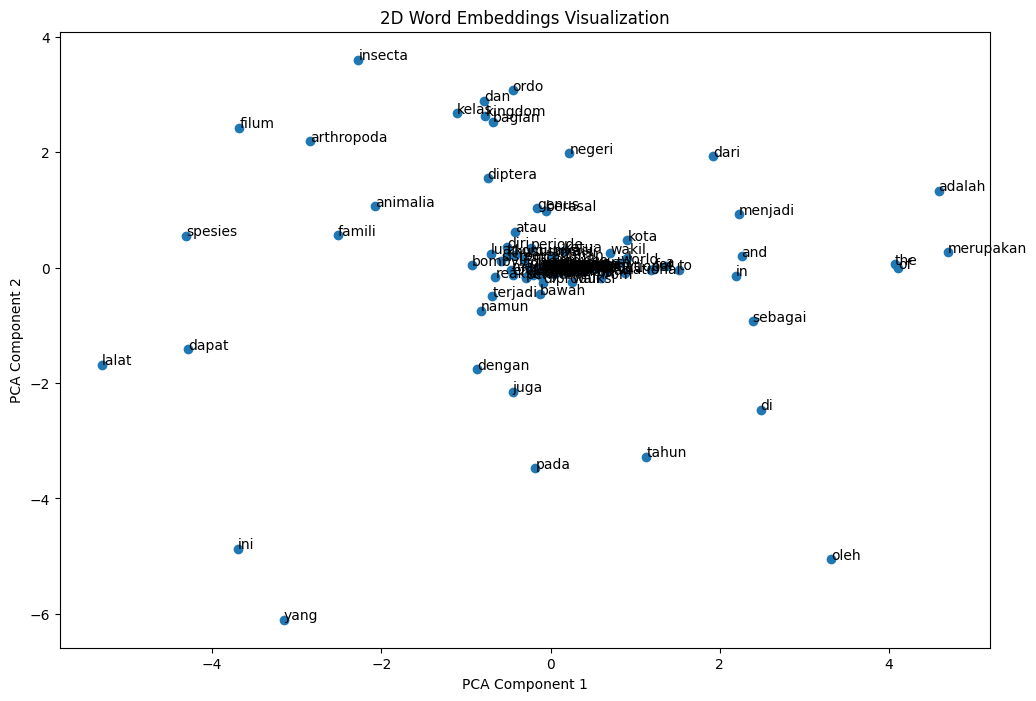

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Function to plot word embeddings in 2D
def plot_embeddings_2d(embeddings, vocab, reverse_vocab, top_n=100):
    """
    Plots the word embeddings in 2D using PCA for dimensionality reduction, excluding <PAD> and <UNK> tokens.

    :param embeddings: The word embeddings matrix (numpy array).
    :param vocab: The vocabulary dictionary with word-to-index mapping.
    :param reverse_vocab: The reverse vocabulary to map indices back to words.
    :param top_n: Number of words to plot (excluding <PAD> and <UNK>).
    """
    # Exclude <PAD> and <UNK> tokens
    excluded_tokens = ['<PAD>', '<UNK>']
    filtered_words = [word for word in vocab.keys() if word not in excluded_tokens]

    # Limit the words to the top_n
    filtered_words = filtered_words[:top_n]

    # Get corresponding indices for the filtered words
    word_indices = [vocab[word] for word in filtered_words]

    # Extract the corresponding embeddings
    selected_embeddings = embeddings[word_indices]

    # Reduce the embeddings to 2D using PCA
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(selected_embeddings)

    # Create a 2D scatter plot
    plt.figure(figsize=(12, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], marker='o')

    # Annotate the points with the words
    for i, word in enumerate(filtered_words):
        plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], word, fontsize=10)

    plt.title(f"2D Word Embeddings Visualization")
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')

    plt.show()

# Example usage:
if __name__ == "__main__":
    # Assuming you've trained your CBOW model
    word_embeddings = model.W1  # Extract the W1 matrix (word embeddings)

    # Now plot the embeddings
    plot_embeddings_2d(word_embeddings, vocab, reverse_vocab, top_n=100)
